In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
#nltk.download('wordnet')

In [32]:
df = pd.read_csv('train.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [33]:
df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [34]:
df.shape

(7613, 5)

In [35]:
df.groupby('target').size()

target
0    4342
1    3271
dtype: int64

In [36]:
dataset = df.copy()

In [37]:
def notnull_binarization(df,key):
    df[key] = df[key].notnull().astype(int)
    return df

def binar_hist(df, key):
    binarized_df = notnull_binarization(df, key)
    filtered_df = binarized_df[binarized_df['target'] == 1]
    grouped_df = filtered_df.groupby(key).size()
    
    grouped_df.plot(kind='bar')
    plt.xlabel(key)
    plt.ylabel('Count')
    plt.show()

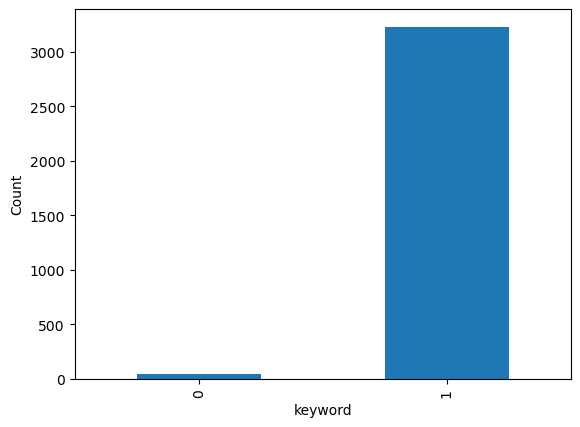

In [38]:
binar_hist(dataset, 'keyword')

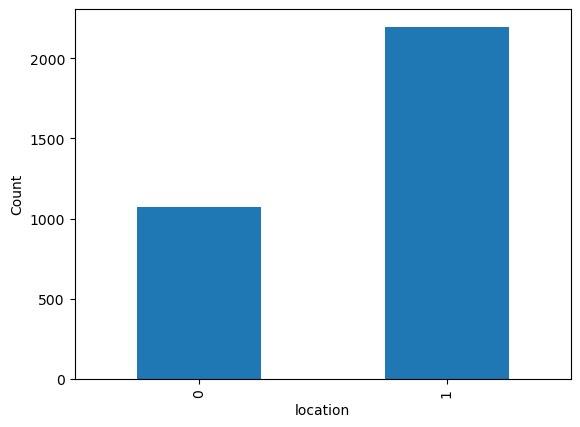

In [39]:
binar_hist(dataset, 'location')

In [40]:
def preprocess_categorial(df):
    df.drop(['id'], axis=1, inplace=True)
    df['keyword'] = df['keyword'].fillna("None")
    df['location'] = df['location'].fillna("None")
    label = LabelEncoder()
    label.fit(df['keyword'])
    df['keyword']=label.transform(df['keyword'])
    label.fit(df['location'])
    df['location']=label.transform(df['location'])
    
def preprocess_binar(df):
    df = notnull_binarization(df, "keyword")
    df = notnull_binarization(df, "location")
    df.drop(['id'], axis=1, inplace=True)
    
def preprocess_mixed(df):
    df = notnull_binarization(df, "location")
    df.drop(['id'], axis=1, inplace=True)
    df['keyword'] = df['keyword'].fillna("None")
    label = LabelEncoder()
    label.fit(df['keyword'])
    df['keyword']=label.transform(df['keyword'])

In [41]:
#preprocess_categorial(df)
preprocess_binar(df)
#preprocess_mixed(df)
target = df['target']
df.drop(['target'], axis=1, inplace=True)
df.head()

,keyword,location,text
0,0,0,Our Deeds are the Reason of this #earthquake M...
1,0,0,Forest fire near La Ronge Sask. Canada
2,0,0,All residents asked to 'shelter in place' are ...
3,0,0,"13,000 people receive #wildfires evacuation or..."
4,0,0,Just got sent this photo from Ruby #Alaska as ...


In [42]:
def tokenize_row(row):
    tokenizer = nltk.tokenize.TreebankWordTokenizer()
    return tokenizer.tokenize(row)

def stem_row(row):
    stemmer = nltk.stem.WordNetLemmatizer()
    tokens = []
    for token in row:
        tokens.append(stemmer.lemmatize(str(token).lower()))
    return tokens

def text_vectorization(df):
    df['text']=df['text'].apply(tokenize_row)
    df['text']=df['text'].apply(stem_row)
    tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1,2))
    features = tfidf.fit_transform([' '.join(row) for row in df['text']])
    features_df = pd.DataFrame(features.todense(), columns=tfidf.get_feature_names_out())
    df.drop(['text'], axis=1, inplace=True)
    df_merged = pd.concat([df, features_df], axis=1)
    return df_merged

In [43]:
df = text_vectorization(df)
#df.drop(['text'], axis=1, inplace=True)

In [44]:
df.shape

(7613, 17530)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.2, random_state=42)

In [46]:
model = LogisticRegression(random_state=0)

In [47]:
model.fit(X_train, y_train)

LogisticRegression(C=10, max_iter=300, random_state=0)

In [48]:
prediction = model.predict(X_test)
prediction

array([0, 0, 1, ..., 1, 1, 1], dtype=int64)

In [49]:
y_test

2644    1
2227    0
5448    1
132     0
6845    0
       ..
1835    0
506     1
3592    1
6740    1
1634    0
Name: target, Length: 1523, dtype: int64

In [50]:
score = precision_score(y_true=y_test, y_pred=prediction)
#Сколько правильных положительных из всех предсказанных положительных
print("Precision score:", score)

Precision score: 0.7986348122866894


In [51]:
r_score = recall_score(y_true=y_test, y_pred=prediction)
#Сколько правильно предсказанных положительных из всех реальных положительных
print("Recall score:",r_score)

Recall score: 0.7211093990755008


In [52]:
a_score = accuracy_score(y_true=y_test, y_pred=prediction)
#Сколько правильно предсказанных от общего колличества
print("Accuracy score:",a_score)

Accuracy score: 0.8036769533814839


In [53]:
ra_score = roc_auc_score(y_true=y_test, y_score=prediction)
print("ROC-AUC score:",ra_score)

ROC-AUC score: 0.7930489787139517


In [54]:
f_score = f1_score(y_true=y_test, y_pred=prediction)
print("F1 score:",f_score)

F1 score: 0.7578947368421053


In [55]:
hyperparameters = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'], 
    'solver': ['liblinear', 'saga']  
}
grid_search = GridSearchCV(
    estimator=model,
    param_grid=hyperparameters,
    scoring='f1',  # метрика оценки качества модели
    cv=2,
    verbose=4
)

In [56]:
#grid_search.fit(X_train, y_train)

In [57]:
#print('Лучшие гиперпараметры: ', grid_search.best_params_)
#print('Лучшая точность: ', grid_search.best_score_)